In [1]:
#I will move this later once mpmc is actually integrated dw
import qmcpy as qp
from mpmc import MPMC
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
initPrice = 120
interest = 0.02
vol = 0.5
callput = 'call'
strike = 130
tfinal = 1/4
d = 52
absTol = 0.05
relTol = 0
sampleSize = 100

In [3]:
temp_error = qp.AsianOption(qp.Sobol(dimension = d, seed = 7), volatility = vol, start_price = initPrice, strike_price=strike,
                           interest_rate = interest, t_final = tfinal, call_put = callput, mean_type = 'arithmetic')
x = temp_error.discrete_distrib.gen_samples(2**20)
y = temp_error.f(x)
global_mean = y.mean()
print(global_mean)

3.3934651065808152


In [4]:
def calc_error(n, y):
    s = 0
    for val in y:
        s += (val - mean)**2
    return s/n

In [ ]:
#back price all above 0 and take back price of that 
# Try with MPMC
w = [0]*52
w[0:3] = [1,1,1]
losses = ['L2ags', 'L2mix', 'L2dis', 'L2ctr', 'L2sym', 'L2ext', 'L2per']
all_err_mpmc = []
all_vals_mpmc = []
for loss in losses: 
    AsianCall = qp.AsianOption(MPMC(dimension = d, weights = w, loss_fn = loss), volatility = vol, start_price = initPrice, strike_price=strike,
                            interest_rate = interest, t_final = tfinal, call_put = callput, mean_type = 'arithmetic')
    vals = []
    stes = []
    y_mean_dif = []
    for i in [16, 32, 64, 128, 256]:
        x = AsianCall.discrete_distrib.gen_samples(i)
        y = AsianCall.f(x)
        mean = y.mean()
        se = calc_error(n = i, y = y)
        vals.append(mean)
        stes.append(se)
        y_mean_dif.append(abs(mean - global_mean))
    stes = np.array(stes)
    vals = np.array(vals)
    y_mean_dif = np.array(y_mean_dif)
    all_err_mpmc.append(y_mean_dif)
    all_vals_mpmc.append(vals)
    print(f"values:{vals}")
    print(f"errors:{stes}")
    print(y_mean_dif)
all_err_mpmc = np.array(all_err_mpmc)
all_vals_mpmc = np.array(all_vals_mpmc)

Since you included weights, you will be using the weighted version of this discrepancy. Set weights = None if you want the unweighted discrepancy.
values:[2.58835225 4.67423019 3.14979691 3.27962576 3.25941601]
errors:[[ 30.30508046]
 [132.17128103]
 [ 51.88599797]
 [ 58.62113442]
 [ 59.37303289]]
[0.80511286 1.28076508 0.2436682  0.11383935 0.1340491 ]
Since you included weights, you will be using the weighted version of this discrepancy. Set weights = None if you want the unweighted discrepancy.
values:[7.42141134 2.98469025 3.80732513 3.36442181 3.33449618]
errors:[[398.9118487 ]
 [ 46.70334676]
 [ 87.44554064]
 [ 62.26985715]
 [ 61.5200994 ]]
[4.02794623 0.40877486 0.41386003 0.02904329 0.05896893]
Since you included weights, you will be using the weighted version of this discrepancy. Set weights = None if you want the unweighted discrepancy.
values:[2.71150471 3.75436811 3.70358114 3.3406445  3.66127119]
errors:[[37.50578493]
 [72.15600456]
 [70.16941301]
 [56.2444861 ]
 [81.53746

<function matplotlib.pyplot.show(close=None, block=None)>

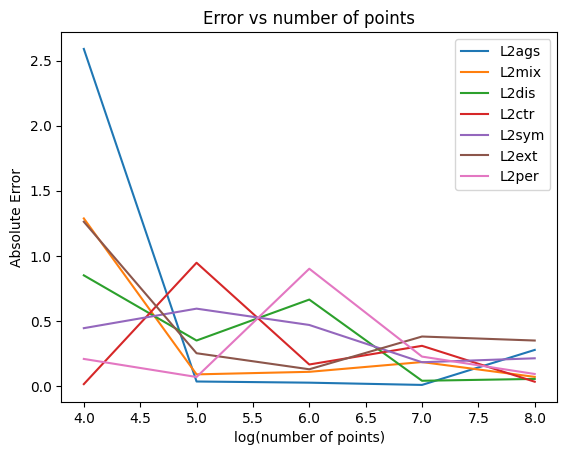

In [7]:
x = [4,5,6,7,8]
y = all_err_mpmc
names = ['L2ags', 'L2mix', 'L2dis', 'L2ctr', 'L2sym', 'L2ext', 'L2per']
for (i,j) in zip(y, names):
    plt.plot(x, i, label = j)
plt.legend()
plt.xlabel('log(number of points)')
plt.ylabel('Absolute Error')
plt.title('Error vs number of points')
plt.show

In [17]:
methods = [
    ("Sobol", lambda: qp.Sobol(dimension=d, seed=7)),
    ("Halton", lambda: qp.Halton(dimension=d, seed=7)),
    ("IID", lambda: qp.IIDStdUniform(dimension=d, seed=7)),
    ("Lattice", lambda: qp.Lattice(dimension=d, seed=7))
]

In [20]:
all_means = []
all_errors = []
for name, method in methods: 
    print(f"Running with {name}...")
    dist = method()
    option = qp.AsianOption(dist, volatility = vol, start_price = initPrice, strike_price=strike,
                           interest_rate = interest, t_final = tfinal, call_put = callput, mean_type = 'arithmetic')
    means = []
    errors = []
    for n in [16, 32, 64, 128, 256]:
        x = option.discrete_distrib.gen_samples(n)
        y = option.f(x)
        mean = y.mean()
        se = calc_error(n=n, y=y)
        means.append(mean)
        errors.append(se)

    means = np.array(means)
    errors = np.array(errors)
    all_means.append(means)
    all_errors.append(errors); 
    
    print(f"Values: {means}")
    # print(f"Errors: {errors}")
all_means = np.array(all_means)
all_errors = abs(all_means - global_mean)

Running with Sobol...
Values: [4.9322758  3.70793891 3.48742258 3.38178599 3.3295773 ]
Running with Halton...
Values: [2.76277725 2.93857633 3.42896074 3.37643431 3.38526366]
Running with IID...
Values: [3.03328493 2.40062163 1.83677285 4.49603977 3.07268203]
Running with Lattice...
Values: [2.50723816 3.24922431 3.0106284  3.31741894 3.42867296]


<function matplotlib.pyplot.show(close=None, block=None)>

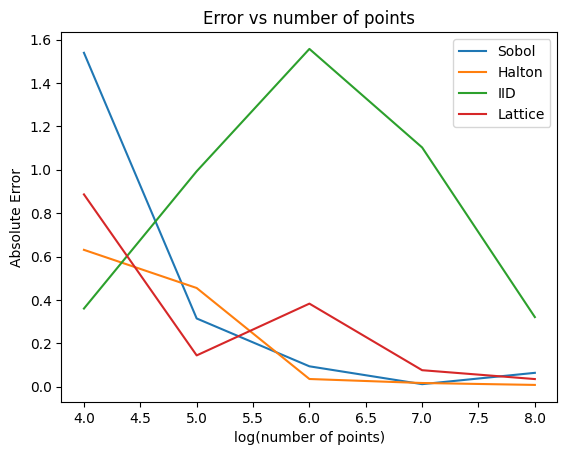

In [21]:
x = [4,5,6,7,8]
y = all_errors
names = ["Sobol", "Halton", "IID", "Lattice"]
for (i,j) in zip(y, names):
    plt.plot(x, i, label = j)
plt.legend()
plt.xlabel('log(number of points)')
plt.ylabel('Absolute Error')
plt.title('Error vs number of points')
plt.show

In [14]:
#Try with Sobol
AsianCall_Sobol = qp.AsianOption(qp.Sobol(dimension = d, seed = 7), volatility = vol, start_price = initPrice, strike_price=strike,
                           interest_rate = interest, t_final = tfinal, call_put = callput, mean_type = 'arithmetic')
temp1 = []
temp2 = []
for i in [16, 32, 64, 128, 256]:
    x = AsianCall_Sobol.discrete_distrib.gen_samples(i)
    y = AsianCall_Sobol.f(x)
    mean = y.mean()
    se = calc_error(n = i, y = y)
    temp1.append(mean)
    temp2.append(se)
vals = np.array(temp1)
stes = np.array(temp2)
print(f"values:{vals}")
print(f"errors:{stes}")

values:[14.12130079 11.07571597 10.51729101 10.31552241 10.15383259]
errors:[[1266.36793169]
 [ 748.86630627]
 [ 565.88627204]
 [ 487.92390263]
 [ 451.43098396]]


In [15]:
abs_tol_val = 0.0005
price, data = qp.CubQMCSobolG(AsianCall_Sobol, abs_tol = abs_tol_val, rel_tol =0).integrate()
print(f"Sobol Price: {price}, Samples: {data.n_total}")


Sobol Price: [10.32601775], Samples: 524288.0
